In [2]:
import sys
import time
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.utils as vutils
import matplotlib.pyplot as plt

import os

In [3]:
print(os.listdir())

['dataset', 'dataset.py', 'dowloadVideo.py', 'eval.py', 'improve2VQ_GAN.py', 'main.ipynb', 'makeNoise.py', 'notebook_vars.json', 'output.json', 'output.txt', 'params', 'samples', 'train.py', 'vgg.py', '__pycache__']


In [4]:
from dataset import VideoClipDataset
from dowloadVideo import VideoDatasetDownloader

from improve2VQ_GAN import VQVAE2VideoSystem

from eval import evaluate_model , print_evaluation_report

from train import train_epoch , setup_vgg , create_optimizers

In [5]:
os.makedirs('dataset', exist_ok=True)
downloader = VideoDatasetDownloader(output_dir='dataset')

downloader.download_youtube_playlist("https://youtube.com/playlist?list=PL35D961BAC58D18F5&si=GzrJdODL3xKb2isb",5)
# downloader.download_youtube_search(query='1 minute nature scenery', max_results=5)

2025-11-19 23:30:21,114 - INFO - ✓ yt-dlp is available
2025-11-19 23:30:21,115 - INFO - Downloading playlist: https://youtube.com/playlist?list=PL35D961BAC58D18F5&si=GzrJdODL3xKb2isb
2025-11-19 23:30:21,116 - INFO - Max videos: 5
2025-11-19 23:31:55,708 - INFO - ✓ Playlist download complete


WindowsPath('dataset')

In [6]:
# Save print to file
# f = open("output.txt", "w", encoding="utf-8")
# sys.stdout = f

In [7]:
# Configuration
# Overall
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset
clip_len = 8
size = (128, 128)

# DataLoader
BATCH_SIZE = 4
num_workers = 4

# Training hyperparameters
num_epochs = 5 # 50
warmup_epochs = 1 # 5
lambda_perc = 0.1  # perceptual loss weight
lambda_gan = 0.1   # GAN loss weight

# Checkpoint and sample intervals
checkpoint_interval = 2 # 5
sample_interval = 2 # 10

In [8]:
# Print
print("Over All")
print(f"\tUsing device: {device}")
print()
print("Dataset")
print(f"\tClip length: {clip_len}")
print(f"\tFrame size: {size}")
print()
print("DataLoader")
print(f"\tBatch size: {BATCH_SIZE}")
print(f"\tNum workers: {num_workers}")
print()
print("Training Hyperparameters")
print(f"\tNum epochs: {num_epochs}")
print(f"\tWarmup epochs: {warmup_epochs}")
print(f"\tPerceptual loss weight: {lambda_perc}")
print(f"\tGAN loss weight: {lambda_gan}")
print()
print("Checkpoint and Sample Intervals")
print(f"\tCheckpoint interval: {checkpoint_interval} epochs")
print(f"\tSample interval: {sample_interval} epochs")

Over All
	Using device: cpu

Dataset
	Clip length: 8
	Frame size: (128, 128)

DataLoader
	Batch size: 4
	Num workers: 4

Training Hyperparameters
	Num epochs: 5
	Warmup epochs: 1
	Perceptual loss weight: 0.1
	GAN loss weight: 0.1

Checkpoint and Sample Intervals
	Checkpoint interval: 2 epochs
	Sample interval: 2 epochs


In [9]:
# Dataset
dataset = VideoClipDataset(
    video_dir="dataset",
    clip_len=clip_len,
    resize=size
)

if len(dataset) == 0:
    raise Exception("Dataset is empty! Please check the video directory and ensure it contains valid video files.")

train_dataset , test_dataset = dataset.train_test_split(split_ratio=0.8)
if len(train_dataset) == 0:
    train_dataset = test_dataset
if len(test_dataset) == 0:
    test_dataset = train_dataset

In [10]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    drop_last=True
)

In [11]:
# print dataset info

print(f"Train ; Dataset: {len(train_dataset)} clips, {len(train_loader)} batches")
print(f"Test  ; Dataset: {len(test_dataset)} clips, {len(test_loader)} batches")

Train ; Dataset: 5291 clips, 1322 batches
Test  ; Dataset: 2084 clips, 521 batches


In [12]:
# Setup Model
# VGG for perceptual loss
setup_vgg(device)

# VQ-GAN model
model = VQVAE2VideoSystem().to(device)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ VGG perceptual loss enabled


In [13]:
# Optimization
optim_G, optim_D = create_optimizers(model, lr=2e-4)

In [14]:
# Train info
print(f"\nTraining for {num_epochs} epochs (warmup: {warmup_epochs})")
print(f"Perceptual weight: {lambda_perc}, GAN weight: {lambda_gan}\n")


Training for 5 epochs (warmup: 1)
Perceptual weight: 0.1, GAN weight: 0.1



In [15]:
train_metrics = []
test_metrics = []

In [16]:
# Best Model Tracking
saveModel = {
    "epoch": None,
    "train_generate_loss": torch.tensor(float('inf'), dtype = torch.float32),
    "train_discriminator_loss": torch.tensor(float('inf'), dtype = torch.float32),
    "test_generate_loss": torch.tensor(float('inf'), dtype = torch.float32),
    "test_discriminator_loss": torch.tensor(float('inf'), dtype = torch.float32),
    "train_metric": None,
    "test_metric": None,
    "param": None,
    "info": "None",
    "path": None
}

def best_Model(model, epoch, train_metrics, test_metrics):
    train_loss = train_metrics[-1]['generate_loss']
    test_loss = test_metrics[-1]['generate_loss']
    if test_loss < saveModel['test_generate_loss']:
        saveModel['epoch'] = epoch + 1 
        saveModel['train_generate_loss'] = train_loss
        saveModel['test_generate_loss'] = test_loss
        saveModel['train_metric'] = train_metrics[-1]
        saveModel['test_metric'] = test_metrics[-1]
        saveModel['param'] = model.state_dict()
        saveModel['info'] = "Best model based on test loss"
        saveModel['path'] = f'params\\best_model.pt'
        torch.save(model.state_dict(), saveModel['path'])

In [17]:
def generate_and_save_samples(model, epoch, device, num_samples=4):
    model.eval()
    with torch.no_grad():
        sample_videos = next(iter(test_loader))
        sample_videos = sample_videos.to(device)

        B, T, C, H, W = sample_videos.shape

        reconstructed_videos = [[None for j in range(T) ]for i in range(B)]
        for t in range(T):
            reconstructed_temp = model.generate(sample_videos[:,t])
            for b in range(B):
                reconstructed_videos[b][t] = reconstructed_temp[b]

        # Save original and reconstructed videos as grids of frames
        for i in range(num_samples):
            try:
                original_frames = sample_videos[i].cpu()
            except:
                original_frames = sample_videos[i]

            try:
                reconstructed_frames = reconstructed_videos[i].cpu
            except:
                reconstructed_frames = reconstructed_videos[i]    
                
            # Create a grid of frames
            original_grid = make_grid(original_frames, nrow=4, normalize=True)
            reconstructed_grid = make_grid(reconstructed_frames, nrow=4, normalize=True)
            
            # Save the grids as images
            os.makedirs(f'samples\\{epoch+1}', exist_ok=True)
            
            vutils.save_image(original_grid, f'samples\\{epoch+1}\\original_epoch{epoch+1}_sample{i+1}.png')
            vutils.save_image(reconstructed_grid, f'samples\\{epoch+1}\\reconstructed_epoch{epoch+1}_sample{i+1}.png')
        
        
            

    model.train()

In [ ]:
# generate_and_save_samples(model,0,device)

: 

In [ ]:

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()
    
    #train
    losses = train_epoch(
        model, train_loader, optim_G, optim_D, device,
        epoch=epoch,
        lambda_perc=lambda_perc,
        lambda_gan=lambda_gan,
        warmup_epochs=warmup_epochs
    )
    train_metrics.append(losses)
    
    epoch_time = time.time() - start_time
    
    # Test and Generate sample reconstruction every 10 epochs
    if (epoch + 1) % sample_interval == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            #test
            metrics = evaluate_model(model, test_loader, device,lambda_perc=lambda_perc, lambda_gan=lambda_gan)
            print_evaluation_report(metrics)
            test_metrics.append(metrics)

            # Generate Sample
            generate_and_save_samples(model,epoch, device)

        model.train()
    else:
        test_metrics.append(test_metrics[-1])
        
    # Print epoch summary
    status = "(warmup)" if epoch < warmup_epochs else ""
    print(f"Epoch {epoch+1}/{num_epochs} {status} - "
            f"G Loss: {losses['generate_loss']:.4f}, "
            f"D Loss: {losses['discriminator_loss']:.4f}, "
            f"Time: {epoch_time:.1f}s")
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % checkpoint_interval == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optim_G_state': optim_G.state_dict(),
            'optim_D_state': optim_D.state_dict(),
            'losses': losses
        }

        # Update best model tracking
        torch.save(checkpoint, f'params\\checkpoint_epoch_{epoch+1}.pt')
        print(f"  → Saved checkpoint_epoch_{epoch+1}.pt")

    best_Model(model, epoch, train_metrics, test_metrics)

    train_metrics[-1]['epoch'] = epoch + 1
    test_metrics[-1]['epoch'] = epoch + 1

    print()  # blank line between epochs

print("Training complete!")
torch.save(model.state_dict(), 'params\\final_model.pt')
print("Saved final_model.pt")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\lpips\weights\v0.1\alex.pth
  Batch 10/1322 (warmup) - G: 0.3728, D: 0.0000
  Batch 20/1322 (warmup) - G: 0.3550, D: 0.0000
  Batch 30/1322 (warmup) - G: 0.3557, D: 0.0000
  Batch 40/1322 (warmup) - G: 0.3500, D: 0.0000
  Batch 50/1322 (warmup) - G: 0.3434, D: 0.0000
  Batch 60/1322 (warmup) - G: 0.3330, D: 0.0000
  Batch 70/1322 (warmup) - G: 0.3283, D: 0.0000
  Batch 80/1322 (warmup) - G: 0.3245, D: 0.0000
  Batch 90/1322 (warmup) - G: 0.3220, D: 0.0000


: 

In [ ]:
print("\nBest Model Summary:")
print(f"  Epoch:             {saveModel['epoch']}")
print(f"  Train Loss:       {saveModel['train_generate_loss']:.6f}")
print(f"  Test Loss:        {saveModel['test_generate_loss']:.6f}")
print(f"  Info:             {saveModel['info']}")
print(f"  Train Metrics:   {saveModel['train_metric']}")
print(f"  Test Metrics:    {saveModel['test_metric']}")


Best Model Summary:
  Epoch:             1
  Train Loss:       0.216672
  Test Loss:        0.214950
  Info:             Best model based on test loss
  Train Metrics:   {'generate_loss': 0.21667198836803436, 'discriminator_loss': 0.0, 'psnr_mean': np.float64(15.112639795730903), 'psnr_std': np.float64(0.03966061154825637), 'ssim_mean': np.float32(0.21526861), 'ssim_std': np.float32(0.0026552042), 'lpips_mean': np.float64(0.9897557129152119), 'lpips_std': np.float64(0.00572107935249361), 'l1_loss': 0.13573110662400723, 'l2_loss': 0.030815385980531573, 'temporal_consistency': np.float64(0.010203623188052902), 'epoch': 1}
  Test Metrics:    {'generate_loss': np.float64(0.21494961716234684), 'discriminator_loss': np.float64(1.1426627337932587), 'psnr_mean': np.float64(15.163140935974473), 'psnr_std': np.float64(0.04705882314259724), 'ssim_mean': np.float32(0.21373329), 'ssim_std': np.float32(0.0027596417), 'lpips_mean': np.float64(0.9836550301406533), 'lpips_std': np.float64(0.0055920068

In [ ]:
'''
train_metrics = [
    {
        'psnr': 28.5,
        'ssim': 0.92,
        'l1_loss': 0.045,
        'lpips': 0.12,
        'temporal_consistency': 0.003,
        'codebook_bottom': {
            'unique_codes_used': 450,
            'total_codes': 512,
            'codebook_usage_pct': 87.9,
            'perplexity': 380.2
        },
        'codebook_top': {
            'unique_codes_used': 210,
            'total_codes': 256,
            'codebook_usage_pct': 82.0,
            'perplexity': 190.5
        }
    },
    {
        'psnr': 28.5,
        'ssim': 0.92,
        'l1_loss': 0.045,
        'lpips': 0.12,
        'temporal_consistency': 0.003,
        'codebook_bottom': {
            'unique_codes_used': 450,
            'total_codes': 512,
            'codebook_usage_pct': 87.9,
            'perplexity': 380.2
        },
        'codebook_top': {
            'unique_codes_used': 210,
            'total_codes': 256,
            'codebook_usage_pct': 82.0,
            'perplexity': 190.5
        }
    }
]

test_metrics = [
    {
        'psnr': 28.5,
        'ssim': 0.92,
        'l1_loss': 0.045,
        'lpips': 0.12,
        'temporal_consistency': 0.003,
        'codebook_bottom': {
            'unique_codes_used': 450,
            'total_codes': 512,
            'codebook_usage_pct': 87.9,
            'perplexity': 380.2
        },
        'codebook_top': {
            'unique_codes_used': 210,
            'total_codes': 256,
            'codebook_usage_pct': 82.0,
            'perplexity': 190.5
        }
    },
    {
        'psnr': 28.5,
        'ssim': 0.92,
        'l1_loss': 0.045,
        'lpips': 0.12,
        'temporal_consistency': 0.003,
        'codebook_bottom': {
            'unique_codes_used': 450,
            'total_codes': 512,
            'codebook_usage_pct': 87.9,
            'perplexity': 380.2
        },
        'codebook_top': {
            'unique_codes_used': 210,
            'total_codes': 256,
            'codebook_usage_pct': 82.0,
            'perplexity': 190.5
        }
    }
]
'''

"\ntrain_metrics = [\n    {\n        'psnr': 28.5,\n        'ssim': 0.92,\n        'l1_loss': 0.045,\n        'lpips': 0.12,\n        'temporal_consistency': 0.003,\n        'codebook_bottom': {\n            'unique_codes_used': 450,\n            'total_codes': 512,\n            'codebook_usage_pct': 87.9,\n            'perplexity': 380.2\n        },\n        'codebook_top': {\n            'unique_codes_used': 210,\n            'total_codes': 256,\n            'codebook_usage_pct': 82.0,\n            'perplexity': 190.5\n        }\n    },\n    {\n        'psnr': 28.5,\n        'ssim': 0.92,\n        'l1_loss': 0.045,\n        'lpips': 0.12,\n        'temporal_consistency': 0.003,\n        'codebook_bottom': {\n            'unique_codes_used': 450,\n            'total_codes': 512,\n            'codebook_usage_pct': 87.9,\n            'perplexity': 380.2\n        },\n        'codebook_top': {\n            'unique_codes_used': 210,\n            'total_codes': 256,\n            'codebook_u

In [ ]:
# train_metrics[0],test_metrics[0]

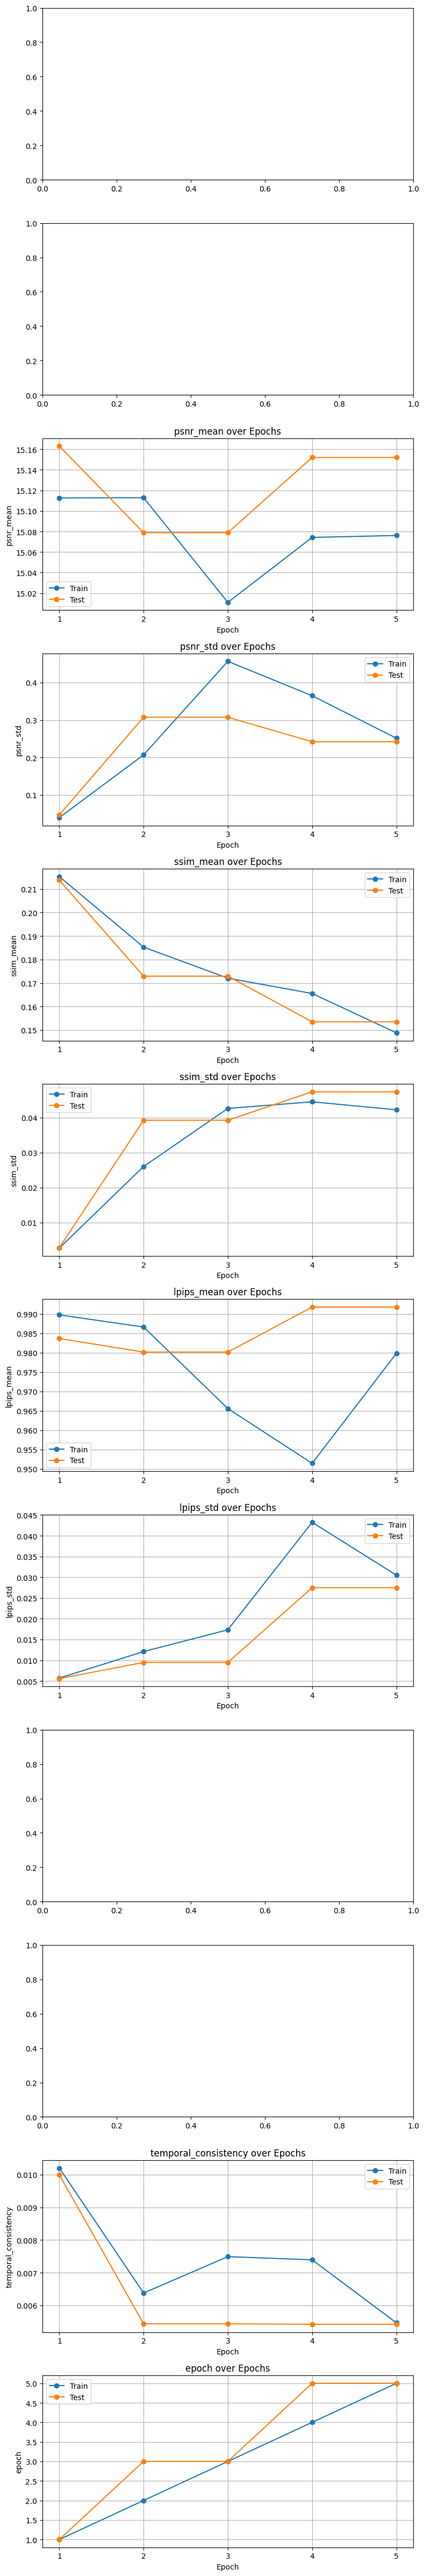

In [ ]:
# Example metrics per epoch

'''
train_metrics = [
    {"accuracy": 0.95, "loss": 0.10, "f1": 0.92},
    {"accuracy": 0.96, "loss": 0.08, "f1": 0.93},
    {"accuracy": 0.97, "loss": 0.07, "f1": 0.94},
]

test_metrics = [
    {"accuracy": 0.92, "loss": 0.12, "f1": 0.89},
    {"accuracy": 0.93, "loss": 0.11, "f1": 0.90},
    {"accuracy": 0.94, "loss": 0.10, "f1": 0.91},
]
'''

# Extract epochs and metric keys
epochs = list(range(1, len(train_metrics)+1))

metric_keys = list(train_metrics[0].keys())
metric_keys = [key for key in metric_keys if not isinstance(train_metrics[0][key], dict)]

train_metric_data = {key: [m[key] for m in train_metrics] for key in metric_keys}
test_metric_data = {key: [m[key] for m in test_metrics] for key in metric_keys}

# Create subplots
fig, axes = plt.subplots(len(metric_keys), 1, figsize=(8, 4 * len(metric_keys)))

for i, key in enumerate(metric_keys):
    ax = axes[i] if len(metric_keys) > 1 else axes

    if "loss" in key:
        continue
    
    if isinstance(train_metric_data[key][0], dict):
        # If the metric is a dictionary (e.g., codebook metrics), skip plotting
        continue
    ax.plot(epochs, train_metric_data[key], marker='o', color='tab:blue', label='Train')
    ax.plot(epochs, test_metric_data[key], marker='o', color='tab:orange', label='Test')
    
    ax.set_title(f"{key} over Epochs")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(key)
    ax.grid(True)
    ax.set_xticks(epochs)
    ax.legend()
    
plt.tight_layout()
plt.show()


In [ ]:
def dictToFloats(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            value = dictToFloats(value)
        else:    
            dictionary[key] = float(value)

def listOfDictsToFloats(metrics):
    for epoch in metrics:
        for key, value in epoch.items():  
            if isinstance(value, dict):
                dictToFloats(value)
            else:
                epoch[key] = float(value)
    

listOfDictsToFloats(train_metrics)
listOfDictsToFloats(test_metrics)

In [ ]:
import json

with open("output.json", "w") as f:
    json.dump({
        "train" : train_metrics,
        "test" : test_metrics
    }, f, indent=4)


In [ ]:
testModel = VQVAE2VideoSystem().to(device)
testModel.load_state_dict(torch.load(saveModel['path']))

<All keys matched successfully>

In [ ]:
testModel.eval()
with torch.no_grad():
    metrics = evaluate_model(testModel, test_loader, device,lambda_perc=lambda_perc, lambda_gan=lambda_gan)
    print_evaluation_report(metrics)
    

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\lpips\weights\v0.1\alex.pth

EVALUATION REPORT

📊 Reconstruction Quality:
  PSNR:              15.17 dB
  SSIM:              0.2137
  L1 Loss:           0.135141
  LPIPS (perceptual): 0.9849

🎬 Temporal Consistency: 0.009915

📚 Codebook Usage:
  Bottom Level:
    Used: 1/512 (0.2%)
    Perplexity: 1.00
  Top Level:
    Used: 1/256 (0.4%)
    Perplexity: 1.00

